#### Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline
from matplotlib import pyplot
import seaborn as sns

import random
import datetime as dt
import pickle
pd.set_option('display.max_columns', None)

In [3]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### Exploratory data analysis

In [4]:
# Read data set 

df = pd.read_excel("Data/Online_Retail.xlsx")

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info()

# The data set contains of 541.909 rows and 8 columns
# For attribute description, see the readme in my repository 
# Keep all the columns as they all contain necessary data. Moreover, later we gonna add some columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.dtypes

# All data types look good. There is no category data type. Later I might seperate the time from the date, in order to analyse the customer shopping behaviour

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [8]:
df.nunique()

print("There are " + str(df.InvoiceNo.nunique()) + " unique orders.")
print("There are " + str(df.StockCode.nunique()) + " unique products.")
print("There are " + str(df.CustomerID.nunique()) + " unique customers.")
print("The customers are from " + str(df.Country.nunique()) + " different countries.")

There are 25900 unique orders.
There are 4070 unique products.
There are 4372 unique customers.
The customers are from 38 different countries.


In [9]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [10]:
df.InvoiceNo.value_counts(dropna=False)

# There is an invoice number which appears 1114 times. This means, one purchase contains 1114 articles 

573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
554023        1
554022        1
554021        1
554020        1
C558901       1
Name: InvoiceNo, Length: 25900, dtype: int64

In [11]:
df.StockCode.value_counts(dropna=False)

# A product that has been sold 2313 times 

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

In [12]:
df.CustomerID.value_counts(dropna=False)

# 135.080 rows with missing customerIDs. That´s a lot! (might drop them later)

NaN        135080
17841.0      7983
14911.0      5903
14096.0      5128
12748.0      4642
            ...  
13270.0         1
17763.0         1
17291.0         1
15668.0         1
15562.0         1
Name: CustomerID, Length: 4373, dtype: int64

In [13]:
df.describe()

# There are negative unit prices and quantity (in case of cancellation). To be removed
# There are ouliters in quantity and unit price that have to be removed

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [14]:
df['Description'].value_counts().head()

# Which items were sold most often

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Description, dtype: int64

### Data cleaning 

##### Null Values Handling

In [15]:
df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [16]:
# drop null values in customer id and description.(nulls in description also have no customer and price, so not needed) We can´t work with null-customers 

df.CustomerID.isnull().values.sum()

135080

In [17]:
df.Description.isnull().values.sum()

1454

In [18]:
df_clean = df.dropna()

In [19]:
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [20]:
df_clean.isna().sum()

# Check if there are missing values in the new dataframe

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

##### Duplicates Removing

In [21]:
df_clean[df_clean.duplicated()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom


In [22]:
df_clean.duplicated().sum()

# In the whole df_clean there are 5225 duplicates. These will be dropped.

5225

In [23]:
df_clean.drop_duplicates(inplace=True)

C:\Users\admin\anaconda3\envs\DA_env\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [24]:
df_clean.duplicated().sum()

0

In [25]:
df_clean.shape

# After dropping dublicates and null values the data set has about 100.000 less rows. Now it´s 401.604

(401604, 8)

##### Negative Values Handling

In [26]:
(df_clean["Quantity"] <= 0).sum()

# There are 8872 transactions with a negative quantity of items. These might be cancellations. Eventhough it would be interesting to analyse the cancellations, for now we drop them

8872

In [27]:
df_clean.loc[df_clean["Quantity"] < 0].count()

InvoiceNo      8872
StockCode      8872
Description    8872
Quantity       8872
InvoiceDate    8872
UnitPrice      8872
CustomerID     8872
Country        8872
dtype: int64

In [28]:
df_clean = df_clean[df_clean["Quantity"] > 0]

In [29]:
df_clean.shape

(392732, 8)

In [30]:
(df_clean["UnitPrice"] <= 0).sum()

# There are 40 transactions where the price per unit is equal/belove 0. These might be mistakes, or maybe free items? E.g. from marketing actions like "buy 2, get 3" or similar. We don´t need them

40

In [31]:
df_clean = df_clean[df_clean["UnitPrice"] > 0]

In [32]:
df_clean.shape

(392692, 8)

In [33]:
# Dropping invoices for cancellations(starting with "C") might be an additional step, to be sure. 
# df_clean[df_clean["InvoiceNo"].str.startswith("C")] - how to read them
# But with the removing of negative quantity values, the cancellations for sure have all been removed (and with that also other mistaken quantity rows)

##### Data Type Changing

In [34]:
df_clean = df_clean.astype({"CustomerID":"int"})

# Change data type of CustomerID from float to integer

In [35]:
df_clean.CustomerID.dtypes

dtype('int32')

In [36]:
df_clean.to_excel('df_retail.xlsx', index=False)

#####  Outliers Removing

In [37]:
df_clean.describe()

# Negative values in unit price and quantity have been removed, but also the positive outliers need to be removed in order for the following modelling

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [38]:
df_clean.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,Quantity,UnitPrice,CustomerID
0.050,1.0,0.42,12626.0
0.950,36.0,8.50,17905.0
0.980,96.0,12.75,18119.0
0.990,120.0,14.95,18211.0
0.999,504.0,49.95,18283.0


Text(0.5, 1.0, 'Quantity and Price Outliers')

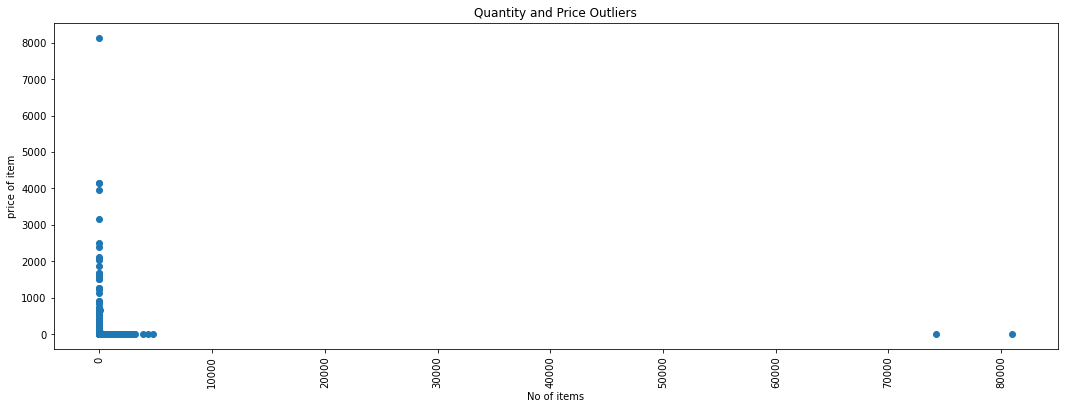

In [39]:
plt.figure(figsize = (18,6))
plt.scatter(data = df_clean, x = "Quantity", y = "UnitPrice")
plt.xticks(rotation = 90)
plt.xlabel("No of items")
plt.ylabel("price of item")
plt.title("Quantity and Price Outliers")

Text(0.5, 1.0, 'Quantity and Price Outliers')

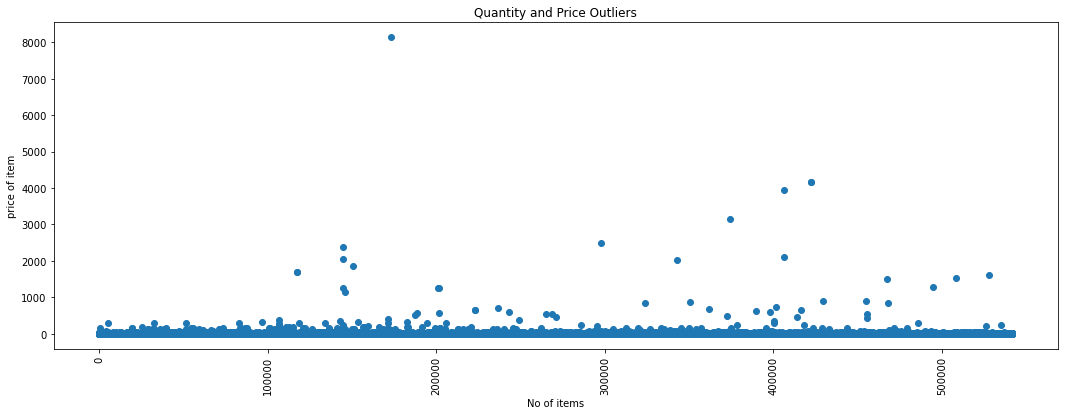

In [40]:
df_clean = df_clean[df_clean["Quantity"] < 1000]
plt.figure(figsize = (18,6))
plt.scatter(x = df_clean.index, y = df_clean["UnitPrice"])
plt.xticks(rotation = 90)
plt.xlabel("No of items")
plt.ylabel("price of item")
plt.title("Quantity and Price Outliers")

# Drop quantity outliers above 1000

Text(0.5, 1.0, 'Quantity and Price Outliers')

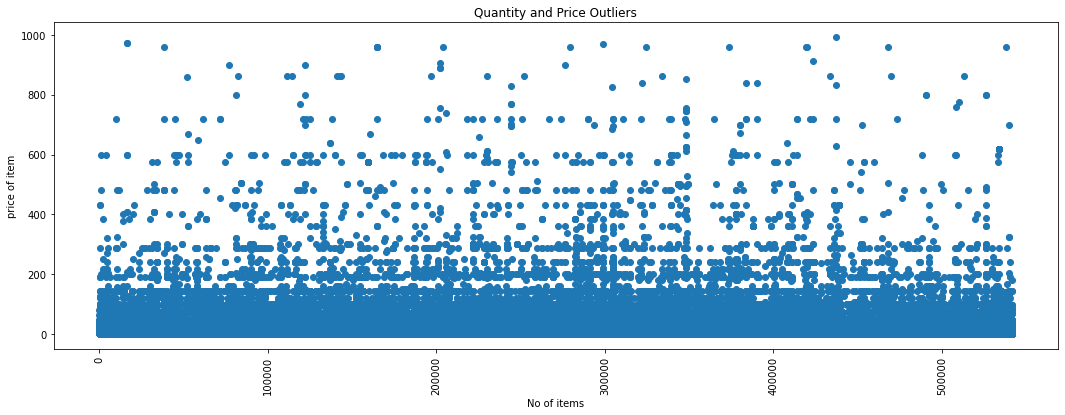

In [41]:
df_clean = df_clean[df_clean['UnitPrice'] < 300]
plt.figure(figsize=(18,6))
plt.scatter(x=df_clean.index, y=df_clean['Quantity'])
plt.xticks(rotation=90)
plt.xlabel("No of items")
plt.ylabel("price of item")
plt.title("Quantity and Price Outliers")

# Drop unit price outliers above 2000

Text(0.5, 1.0, 'Quantity and Price Outliers')

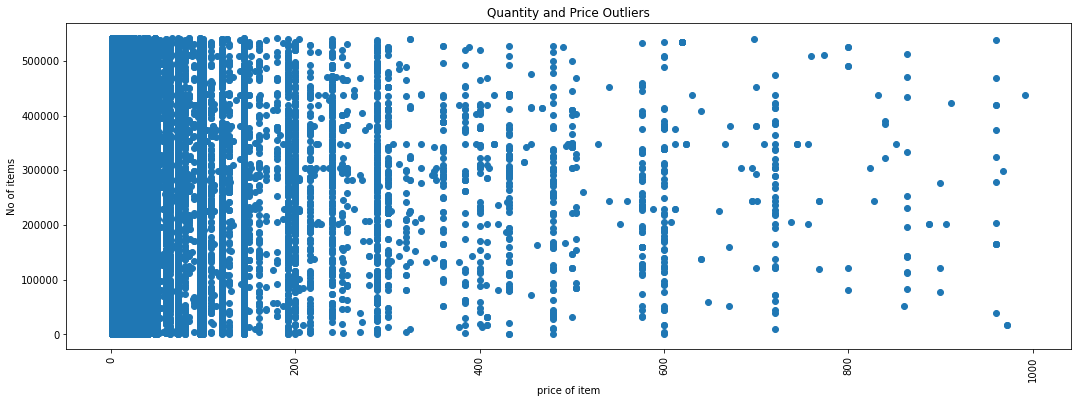

In [42]:
df_clean = df_clean[df_clean['UnitPrice'] < 300]
plt.figure(figsize=(18,6))
plt.scatter(y=df_clean.index, x=df_clean['Quantity'])
plt.xticks(rotation=90)
plt.ylabel("No of items")
plt.xlabel("price of item")
plt.title("Quantity and Price Outliers")

# Drop unit price outliers above 300

In [43]:
df_clean.describe()

# This was a conservative dropping of outliers. Check if keep unit price only until 500 instead

,Quantity,UnitPrice,CustomerID
count,392524.000000,392524.000000,392524.000000
mean,12.272564,2.950675,15287.907705
std,31.576436,4.531552,1713.466986
min,1.000000,0.001000,12347.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,992.000000,295.000000,18287.000000


In [44]:
df_clean.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,Quantity,UnitPrice,CustomerID
0.050,1.0,0.42,12626.0
0.950,36.0,8.50,17905.0
0.980,96.0,12.75,18119.0
0.990,120.0,14.95,18211.0
0.999,480.0,40.00,18283.0


### Feature Engineering

In [45]:
# The data set contains information for the amount of items per purchase(invoice) and the price per unit. 
# Add a column with the whole value of a purchase "TotalAmount"

In [46]:
df_clean["TotalAmount"] = df_clean["Quantity"] * df_clean["UnitPrice"]

In [47]:
df_clean = df_clean[["InvoiceNo", "InvoiceDate", "StockCode", "Description", "Quantity", "UnitPrice", "TotalAmount", "CustomerID", "Country"]]
df_clean.head()

,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,TotalAmount,CustomerID,Country
0,536365,2010-12-01 08:26:00,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,71053,WHITE METAL LANTERN,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,17850,United Kingdom


In [48]:
df_clean.TotalAmount.dtype

dtype('float64')

##### Customers and the number of their orders

In [49]:
df_frequency =  df_clean[["CustomerID", "InvoiceNo"]].groupby("CustomerID", as_index = False).count()
df_frequency.rename(columns = {"InvoiceNo": "Frequency"}, inplace = True)
df_frequency

# Group the features by the customer, create new frame for that.
# Count the frequency of invoice numbers, which means the frequency of orders per customer 

,CustomerID,Frequency
0,12347,182
1,12348,31
2,12349,72
3,12350,17
4,12352,84
...,...,...
4322,18280,10
4323,18281,7
4324,18282,12
4325,18283,721


##### Customers and the customer lifetime value

In [50]:
df_monetary = df_clean[["CustomerID", "TotalAmount"]].groupby("CustomerID", as_index = False).sum()
df_monetary.rename(columns = {"TotalAmount" : "Monetary"}, inplace = True)
df_monetary

# Group total amount of sales per customer 

,CustomerID,Monetary
0,12347,4310.00
1,12348,1797.24
2,12349,1457.55
3,12350,334.40
4,12352,2129.54
...,...,...
4322,18280,180.60
4323,18281,80.82
4324,18282,178.05
4325,18283,2045.53


In [51]:
df_merge = df_monetary.merge(df_frequency, on = "CustomerID", how = "inner")
df_merge

,CustomerID,Monetary,Frequency
0,12347,4310.00,182
1,12348,1797.24,31
2,12349,1457.55,72
3,12350,334.40,17
4,12352,2129.54,84
...,...,...,...
4322,18280,180.60,10
4323,18281,80.82,7
4324,18282,178.05,12
4325,18283,2045.53,721


##### Customer and the last purchase

In [52]:
df_recency = df_clean[["CustomerID", "InvoiceDate"]].groupby("CustomerID", as_index = False).max()
df_recency.rename(columns = {"InvoiceDate": "LastPurchaseDate"}, inplace = True)
df_recency

# Find the date of the last order per customer 

,CustomerID,LastPurchaseDate
0,12347,2011-12-07 15:52:00
1,12348,2011-09-25 13:13:00
2,12349,2011-11-21 09:51:00
3,12350,2011-02-02 16:01:00
4,12352,2011-11-03 14:37:00
...,...,...
4322,18280,2011-03-07 09:52:00
4323,18281,2011-06-12 10:53:00
4324,18282,2011-12-02 11:43:00
4325,18283,2011-12-06 12:02:00


In [53]:
no_days_last_purchase = df_clean["InvoiceDate"].max() - df_recency["LastPurchaseDate"] 
no_days_last_purchase = no_days_last_purchase + pd.Timedelta("1 days")
no_days_last_purchase

# It´s more helpful to not know the date of the last purchase, but the count of days that past since the last purchase 

0        2 days 20:58:00
1       75 days 23:37:00
2       19 days 02:59:00
3      310 days 20:49:00
4       36 days 22:13:00
              ...       
4322   278 days 02:58:00
4323   181 days 01:57:00
4324     8 days 01:07:00
4325     4 days 00:48:00
4326    43 days 03:21:00
Name: LastPurchaseDate, Length: 4327, dtype: timedelta64[ns]

In [54]:
days_since_last_purchase = pd.Series(data = [d.days for d in no_days_last_purchase], index = df_merge.index)
days_since_last_purchase

0         2
1        75
2        19
3       310
4        36
       ... 
4322    278
4323    181
4324      8
4325      4
4326     43
Length: 4327, dtype: int64

In [55]:
df_merge["Recency"] = days_since_last_purchase
df_merge

# Now we have grouped all the rows down to per customer. Only 4327 rows left

# Should we keep the CustomerID column for the modell? How else do we then know, which customer is in which cluster? 

,CustomerID,Monetary,Frequency,Recency
0,12347,4310.00,182,2
1,12348,1797.24,31,75
2,12349,1457.55,72,19
3,12350,334.40,17,310
4,12352,2129.54,84,36
...,...,...,...,...
4322,18280,180.60,10,278
4323,18281,80.82,7,181
4324,18282,178.05,12,8
4325,18283,2045.53,721,4


In [56]:
df_merge.describe()

,CustomerID,Monetary,Frequency,Recency
count,4327.000000,4327.000000,4327.000000,4327.000000
mean,15298.752947,1934.511568,90.715045,92.555581
std,1721.231803,8166.658446,225.649953,100.055558
min,12347.000000,2.900000,1.000000,1.000000
25%,13812.500000,304.515000,17.000000,18.000000
50%,15298.000000,664.000000,41.000000,51.000000
75%,16778.500000,1637.450000,98.000000,142.000000
max,18287.000000,270283.460000,7676.000000,374.000000


In [57]:
df_merge.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,CustomerID,Monetary,Frequency,Recency
0.050,12615.300,110.9290,4.000,3.0
0.950,17979.700,5675.0020,308.000,312.0
0.980,18170.480,10691.9108,476.000,361.0
0.990,18225.740,17247.3626,655.740,369.0
0.999,18279.348,121664.8225,2575.614,374.0


#### Handling outliers of the new features 

In [58]:
df_merge = df_merge[df_merge["Monetary"] < 2500]

# In first iteration I removed all above 10.000, second interation <4000

In [59]:
df_merge = df_merge[df_merge["Frequency"] < 200]

# In first iteration I removed all above 500, second second interation <250

In [60]:
df_merge.describe()

,CustomerID,Monetary,Frequency,Recency
count,3526.000000,3526.000000,3526.000000,3526.000000
mean,15336.087351,690.591898,43.860465,107.000851
std,1709.537112,576.582518,39.828025,103.719705
min,12348.000000,2.900000,1.000000,1.000000
25%,13849.250000,251.287500,14.000000,24.000000
50%,15343.500000,498.450000,30.000000,65.000000
75%,16804.750000,978.822500,62.000000,174.000000
max,18287.000000,2495.870000,197.000000,374.000000


In [61]:
df_merge.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,CustomerID,Monetary,Frequency,Recency
0.050,12646.50,102.4200,4.000,4.0
0.950,17994.75,1960.4700,127.000,320.0
0.980,18175.00,2239.4350,156.000,365.0
0.990,18226.25,2363.1625,175.500,372.0
0.999,18278.95,2482.3175,195.475,374.0


In [62]:
fig, axis = plt.subplots(nrows = 1, ncols = 3, 
                         figsize = (15, 4), dpi = 100,
                         sharex = False, sharey = False,
                         gridspec_kw = {'height_ratios': [3, 1]})
sns.distplot(df_merge["Monetary"])
sns.distplot(df_merge["Frequency"])
sns.distplot(df_merge["Recency"])

ValueError: Expected the given number of height ratios to match the number of rows of the grid

<Figure size 1500x400 with 0 Axes>

In [ ]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, 
                         figsize = (15, 4), dpi = 100,
                         sharex = False, sharey = False,
                         gridspec_kw = {'height_ratios': [3, 1]}
                         )

# Monetary
axis[0, 0].hist(df_merge['Monetary'], bins = 'sturges', facecolor = 'red', edgecolor = 'black')
sns.boxplot(x = 'Monetary', data = df_merge,  color = 'red', ax = axis[1, 0])
axis[0, 0].set_title("Histogram & Boxplot for Monetary")

# Frequency
axis[0, 1].hist(df_merge['Frequency'], bins = 'sturges', facecolor = 'green', edgecolor = 'black')
sns.boxplot(x = 'Frequency', data = df_merge,  color = 'green', ax = axis[1, 1])
axis[0, 1].set_title("Histogram & Boxplot for Frequency")

# Recency
axis[0, 2].hist(df_merge['Recency'], bins = 'sturges', facecolor = 'purple', edgecolor = 'black')
sns.boxplot(x = 'Recency', data = df_merge,  color = 'purple', ax = axis[1, 2])
axis[0, 2].set_title("Histogram & Boxplot for Recency")

plt.show()

# it´s visible that Monetary and Frequency contain outliers, the plots are skewed

In [ ]:
df_merge.shape

### Feauture Scaling

##### Standardization
K-Means is a distance based algorithm, thus the features need to be scaled/ normalized

In [ ]:
df_scale = df_merge[["Monetary","Frequency","Recency"]]         

# Create new data frame only with the 3 features needed, without customer id. But how do I identify the customer in each cluster later on? 
# This is the first try, in the second I would change the customer id column as index 

# Set a single column as Index:  df.set_index('column')

In [ ]:
scaler = StandardScaler()
scaler.fit(df_scale)
df_scaled = scaler.transform(df_scale)

df_rfm_scaled = pd.DataFrame(df_scaled, columns = df_scale.columns)

display(df_scale.head())
print()
display(df_rfm_scaled.head())

# The scaled features are now ready for the clustering! 

### Clustering with K Means

K-means picks randomly the initial centroids, but it needs an input for the inital number of clusters. We start with 6 clusters

In [ ]:
kmeans = KMeans(n_clusters = 6, init = "k-means++", random_state = 1234)
kmeans.fit(df_rfm_scaled)

In [ ]:
clusters = kmeans.predict(df_rfm_scaled)
pd.Series(clusters).value_counts().sort_index()

# Number of observations each cluster contains. Cluster 3 is way bigger than the others. The clustering did not went well with 6 clusters

In [ ]:
cluster_labels = pd.Series(data = kmeans.labels_, index = df_scale.index)

df_mean1 = pd.concat([df_scale, cluster_labels], axis = 1)
df_mean1.columns = list(df_scale.columns) + ["ClusterNo"]
df_mean1

# Save the labels in a series and concat to data frame with MFR features in order to get an overview about the cluster
# Why are there Nan in ClusterNo? 

In [ ]:
import plotly.express as px

plotly_fig = px.scatter_3d(df_mean1, x = "Monetary", y = "Frequency", z = "Recency", color = "ClusterNo")
plotly_fig.show()

# From the plot it is obvious, that 6 clusters don´t cluster the MFR features approbriately

In [ ]:
# assign a cluster to each example
labels = kmeans.predict(df_rfm_scaled)
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(df_scale.to_numpy()[row_ix, 1], df_scale.to_numpy()[row_ix, 2])
    # show the plot
    plt.clim(-0.5, 5.5)
pyplot.show()

#### Elbow Method to choose Number of Clusters

In [ ]:
K = range(2,10)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters = k,
                    random_state = 1234)
    kmeans.fit(df_rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertia, "bx-")
plt.xlabel("No of clusters")
plt.ylabel("Inertia")
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title("Elbow Method showing the optimal K")

The elbow is visible at 3, but also 5 might be a slight elbow. Choosing number of clusters also could depend on business decisions/experience.

#### Silhouette Score to choose Number of Clusters

The Silhouette Score measures how similar an observation is to its own cluster compared to other clusters

In [ ]:
silhouette = []

for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 1234)
    kmeans.fit(df_rfm_scaled)
    filename = "Model/Kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    silhouette.append(silhouette_score(df_rfm_scaled, kmeans.predict(df_rfm_scaled)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, "bx-")
plt.xlabel("No of cluster")
plt.ylabel("Silhouette score")
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title("Silhouette Curve showing optimal K")

# Determine the optimal number of clusters, in the range 2-9
# As the number of clusters increases, the similarity of points within a cluster decreases. 
# The greater the score, the greater the separation between the clusters. The clusters then are more defined.

# I am not sure how to interpret the curve: There is a distortion towards 4, but the score increases again towards 5 (and score is higher at 5, than at 4)
# Thus, I continue with 5 clusters        

In [ ]:
score = silhouette_score(df_rfm_scaled, kmeans.labels_, metric ="euclidean")
print("Silhouette Score: %.3f" % score)

# The closer the Silhouette Score is to 1, the better 

#### Adjusting K in iterations (5 Cluster)

inertia is the mean squared distance between each instance and its closest centroid

In [ ]:
kmeans2 = KMeans(n_clusters = 5, init = "k-means++", random_state = 1234)
kmeans2.fit(df_rfm_scaled)

In [ ]:
kmeans.inertia_

In [ ]:
clusters2 = kmeans2.predict(df_rfm_scaled)
pd.Series(clusters2).value_counts()

In [ ]:
cluster_labels2 = pd.Series(data = kmeans2.labels_, index = df_scale.index)

df_means2 = pd.concat([df_scale, cluster_labels2], axis = 1)
df_means2.columns = list(df_scale.columns) + ["ClusterNo"]
df_means2

In [ ]:
plotly_fig2 = px.scatter_3d(df_means2, x = "Monetary", y = "Frequency", z = "Recency", color = "ClusterNo")
plotly_fig2.show()

# From the plot it is obvious, that 6 clusters don´t cluster the MFR features approbriately

In [ ]:
# assign a cluster to each example
labels = kmeans2.predict(df_rfm_scaled)
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(df_scale.to_numpy()[row_ix, 1], df_scale.to_numpy()[row_ix, 2])
    plt.clim(-0.5, 4.5)
    
pyplot.show()

In [ ]:
score = silhouette_score(df_rfm_scaled, kmeans2.labels_, metric ="euclidean")
print("Silhouette Score: %.3f" % score)

# The closer the Silhouette Score is to 1, the better 

In [ ]:
df_means2.groupby("ClusterNo").mean()

# Have a look at the clusters: cluster 1 is interesting, they spend a lot (similar to cluster 4), but not buy as frequent as cluster 4

In [ ]:
df_means2.groupby("ClusterNo").describe()

#### Insights gathering from 5 customer segments:

Cluster 0:
- 1271 customer 
- 15 pound per order on average 
- not frequent orderering, last order aprox. 2 months ago

Cluster 1:
- 717 customer
- 21 pound on average per order, high value purchases 
- average frequent shopper 

Cluster 2:
- 890 customer 
- 16 pound average/order
- cold shopper with risk to loose 
- need to take action, as this is a huge cluster 

Cluster 3:
- 263 Customer 
- only 6 pound average/order 
- but most frequent shopper (average every 3rd day (365/124)

Cluster 4:
- 385 customer
- 19 pound average/order
- high value orders, frequent shopper 
- most recent order, about 1 month ago 
- this is a very interesting cluster, very hot and valuable 

#### Adjusting K in iteration (3 Cluster)

In [ ]:
kmeans3 = KMeans(n_clusters = 3, init = "k-means++", random_state = 1234)
kmeans3.fit(df_rfm_scaled)

In [ ]:
clusters3 = kmeans3.predict(df_rfm_scaled)
pd.Series(clusters3).value_counts()

In [ ]:
cluster_labels3 = pd.Series(data = kmeans3.labels_, index = df_scale.index)

df_means3 = pd.concat([df_scale, cluster_labels3], axis = 1)
df_means3.columns = list(df_scale.columns) + ["ClusterNo"]
df_means3

In [ ]:
plotly_fig3 = px.scatter_3d(df_means3, x = "Monetary", y = "Frequency", z = "Recency", color = "ClusterNo")
plotly_fig3.show()

# From the plot it is obvious, that 3 clusters cluster the MFR features approbriately

In [ ]:
# assign a cluster to each example
labels = kmeans3.predict(df_rfm_scaled)
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(df_scale.to_numpy()[row_ix, 1], df_scale.to_numpy()[row_ix, 2])
    plt.clim(-0.5, 2.5)
  
pyplot.show()

In [ ]:
score = silhouette_score(df_rfm_scaled, kmeans3.labels_, metric ="euclidean")
print("Silhouette Score: %.3f" % score)

# The closer the Silhouette Score is to 1, the better 

### Decision on Number of Cluster: 3 Cluster

The silhouette score as well as the elbow method show, that the optimal clustering of the features happens within 3 clusters. I continue with them. But working with K-Means means working in iterations. 
For future steps: Redefine outliers to smaller ones and iterate the clustering with smaller range of rows

In [ ]:
df_means3.groupby("ClusterNo").mean()

# Let´s have a first look at the 3 clusters: We see that cluster 1 are the most attractive customer segment. They spend the most money and shop the most frequent. 

In [ ]:
df_means3.groupby("ClusterNo").describe()

#### Evaluation and Conclusion from the 3 clusters:


CLUSTER 0:
- 935 customers
- Monetary: The total sales is the lowest of all 3 clusters. These customers spend the least of all.(TotalAmount)
- Frequency: The number of purchases is also the lowest.(count of InvoiceNo)
- Recency: The last purchase was 257 days ago. These customer may already be churned.
- Lowest/worst values of all attributes
- These customer used to order relatively similar/frequent to cluster 2, with a slightly lower freuency but similar amount spend. But they only order ca. 1,5 times per year.
- These customers very probably order only christmas related decoration items 
--> There is a danger that these customers get cold or don´t come back

CLUSTER 1:
- 906 customers
- Monetary: Sales are 3 to 4 times higher than the other clusters.  
- Frequency: Number of purchases is also 3,5 to 5 times higher than other clusters. 
- Recency: They buy the most frequent and thus the last order was only a bit more than a month ago. Purchases every 1,5 month
- It might look, like these customers spend way more than the other clusters. But in average they spend similar to the others, but only more frequent
- These customers probably buy very diverse items, maybe houseware and practical stuff  
--> These are the most loyal customers. 
--> Average value is lower than cluster 2, 
--> Emphasis on increasing basket size: recommendations for other low value items, special set prices, bulk discount

CLUSTER 2:
- 1685 customers
- Monetary: Middle value for total sales
- Frequency: 3 times less frequent than cluster 1, purchase once per month 
- Recency: Last purchase almost two months ago 
- These customers probably not only purchase christmas decoration, but also for other occasions like easter, valentines day, halloween and maybe housewares
--> Biggest cluster, with loyal customer, who generate most revenue. 
--> The company should focus on this cluster. Either by increasing the engagement rate: occasional special offers or sales: recommendations (low value/higher value items, increase basket size, limited edition products, bulk discounts. 
--> Priority cluster



With this customer segmentation, the company understands their customer and their behaviour better. This helps in better and accurate targeting of the different segments and tailored marketing and sales activities. 


    Customers who recently bought items, are also the ones who buy more freqently and place high value orders
    Customers who transacted long time ago, also place lower valued orders
    Customers who buy occasionally, do not tend to buy expensive items

AVERAGE ORDER VALUE??? 

##### Idea for visualization: Radar Chart 
https://www.python-graph-gallery.com/391-radar-chart-with-several-individuals 

#### Saving the Model 

In [ ]:
with open("Model/Scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)

with open("Model/Kmeans3.pickle", "wb") as f:
    pickle.dump(kmeans3,f)

In [ ]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
    except FileNotFoundError: 
        print("File not found!")

In [ ]:
scaler2 = load("Model/scaler.pickle")
scaler2

### Visual Evaluation of Clusters (in Tableau)

Here only for conceptualization

In [ ]:
# Distribution/ Size of Clusters (Cluster 2 almost douple size)

pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=["Monetary", "Frequency", "Recency"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [ ]:
# Clusters profile based on other feature: e.g. Country  - as scatterplott 

### Visual EDA 

In [ ]:
invoice_count = df_clean["InvoiceNo"].value_counts().sort_values(ascending=False).iloc[0:10]
plt.figure(figsize =(14,4))
sns.barplot(invoice_count.index, invoice_count.values, palette = sns.cubehelix_palette(10))
plt.ylabel("No of items")
plt.title("Which invoices include the most items?");
plt.xticks(rotation = 90);

In [ ]:
item_count = df_clean["Description"].value_counts().sort_values(ascending=False).iloc[0:10]
plt.figure(figsize = (14,4))
sns.barplot(item_count.index, item_count.values, palette = sns.cubehelix_palette(10))
plt.ylabel("No of items")
plt.title("Top sold items");
plt.xticks(rotation = 90);

In [ ]:
plt.figure(figsize=(18,6))
sns.countplot(df_clean[df_clean['Country'] != 'United Kingdom']['Country'])
plt.xticks(rotation=90)

# PLOTTING AS MAP ALSO POSSIBLE 

In [ ]:
correlation = df_clean.corr()
correlation

In [ ]:
plt.figure(figsize=(12,7))

sns.heatmap(correlation,annot=True,cmap='crest')

# If two features correlate, that means they contain the same information. One should be removed for the modelling

In [ ]:
correla = df_merge.corr()
correla

In [ ]:
plt.figure(figsize=(12,7))

sns.heatmap(correla,annot=True,cmap='crest')

#### Save data to excel

In [ ]:
#df_clean.to_excel('df_retail.xlsx', index=False)

In [ ]:
#df_purchases.to_excel('df_purchases.xlsx', index=False)

## Appendix

#### Adjusting K in iteration (4 Cluster)

In [ ]:
kmeans4 = KMeans(n_clusters = 4, init = "k-means++", random_state = 1234)
kmeans4.fit(df_rfm_scaled)

In [ ]:
clusters4 = kmeans4.predict(df_rfm_scaled)

In [ ]:
cluster_labels4 = pd.Series(data = kmeans4.labels_, index = df_scale.index)

df_means4 = pd.concat([df_scale, cluster_labels4], axis = 1)
df_means4.columns = list(df_scale.columns) + ["ClusterNo"]

In [ ]:
plotly_fig4 = px.scatter_3d(df_means4, x = "Monetary", y = "Frequency", z = "Recency", color = "ClusterNo")
plotly_fig4.show()


In [ ]:
df_means4.groupby("ClusterNo").describe()

Cluster 0:
- 503 customer
- with distance the most valuable customers
- spend 14 pound per order on average
- shop highly frequently (every 3rd day of the year 365/116=3)
- last order was 1,5 months ago
- these customers might order very frequently in regards of holidays, eg. several orders before christmas 

Cluster 1:
- 890 customer
- spend 17 pound on average per order
- occasional shopper, not so hot customer 
- last order was 37 weeks ago 
- customer who are cold with risk to loose 

Cluster 2:
- 869 customer
- spend 17 pound on average per order 
- orders every second month and quite regularly
- these customer might buy items for everyday usage and not only decorations for holidys like christmas

Cluster 3:
- 1264 customer
- 16 pound on average per order 
- only occasional shopper
- last order was two months ago 